In [32]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import numpy as np
from datetime import datetime
import xarray as xr
from xarray.backends import NetCDF4DataStore
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from matplotlib.colors import Normalize
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import metpy.calc as mpcalc
from scipy.ndimage import gaussian_filter

In [33]:
MODEL = 'hrrr'
RUN_DATE = '20220628'
RUN_TIME = '19'
START_HOUR = 2
END_HOUR = 7

## Model Reflectivity

In [34]:
%%capture

# Define area to plot
BOTTOM_LAT = 23
TOP_LAT = 40
LEFT_LON = -97
RIGHT_LON = -70

# Model Endpoints 
hrrr = f'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr{RUN_DATE}/hrrr_sfc.t{RUN_TIME}z'
arw = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw20200430/hiresw_conusarw_12z'
nbm = 'https://nomads.ncep.noaa.gov/dods/blend/blend20200417/blend_1hr_22z'
rap = 'https://nomads.ncep.noaa.gov/dods/rap/rap20200503/rap_21z'
gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs20200429/gfs_0p25_18z'

base_url = hrrr

ds = xr.open_dataset(base_url, decode_times=True)
ds = ds.metpy.parse_cf()

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)

if base_url == gfs:
    LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)
else:
    LON_SLICE = slice(LEFT_LON, RIGHT_LON)
    
# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values

if base_url == gfs:
    lons = ds.lon.sel(lon=LON_SLICE).values
else:
    lons = 360 + ds.lon.sel(lon=LON_SLICE).values

# Capture model variable we want to plot
data = ds.refcclm

## Time Conversion from UTC to Eastern Time

In [35]:
def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

## Setup Basemap
Build this outside of the forecast loop since these features stay the same

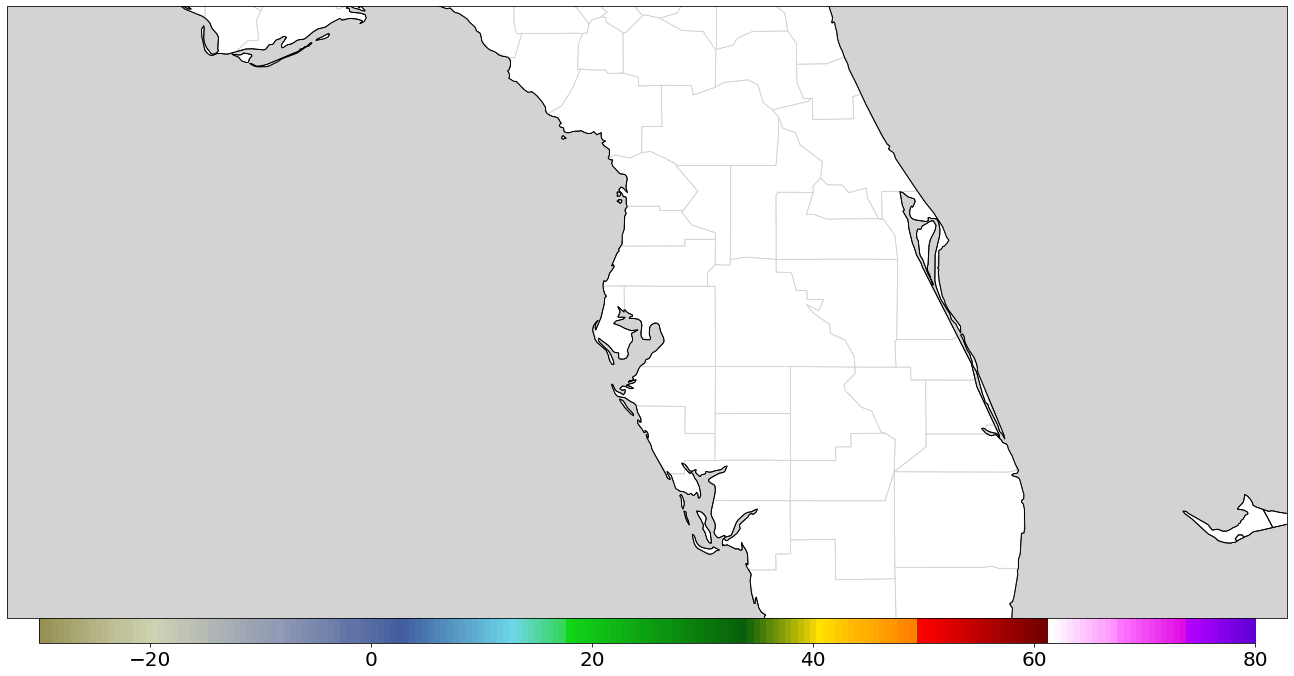

In [36]:
#%%capture
# Setup matplotlib figure
fig = plt.figure(figsize=(1280/72, 720/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', zorder=2, linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.00, zorder=3)
ax.set_extent([-84, -81, 26, 30]) #Tampa Area
ax.set_adjustable('datalim')

norm, cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', 20, 5)
#cm = plt.cm.get_cmap('gist_ncar')
xy = range(80)
z = xy
sc = plt.scatter(xy, xy, c=z, s=35, cmap=cmap, norm=Normalize(-30, 80))
cbar = plt.colorbar(sc, orientation='horizontal', pad=0, aspect=50, shrink=0.95)
cbar.ax.tick_params(labelsize=20)

## Model Time Series
Function to plot model data and manage text/contours so they're removed before the next timestep is plotted

In [37]:
artists = []

for time_step in range(START_HOUR, END_HOUR):
    # [contourf.remove() for contourf in contour_fill.collections if time_step > 1]
    
    refl = data.isel(time=time_step)
    local_time = convert_datetime_from_nomads_to_local(str(refl.time.values).split('.')[0])
    refl = refl.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE).squeeze().metpy.unit_array

    reflectivity_values = np.arange(20, 80, 5)

    contour_fill = ax.contourf(lons, lats, refl, reflectivity_values, zorder=1,
                               cmap=cmap, norm=Normalize(-30, 80), transform=ccrs.PlateCarree())
    
    add_arts = contour_fill.collections

    text = ax.text(0.02, 0.95, s=f'Model Simulated Radar\n{local_time}',
                   fontsize=36, fontweight='bold', fontname='Arial',
                   color='white', bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
                   transform=ax.transAxes, zorder=10, va='top')
    
    artists.append(add_arts + [text])


## Display JS Animator within Jupyter Lab
Execute the code that builds the animation

In [38]:
plt.rcParams['animation.html'] = 'jshtml'

anim = ArtistAnimation(fig, artists, 
                       interval=300, 
                       repeat_delay=2000,
                       repeat=True)
anim

## Write MP4 and GIF

In [ ]:
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'

#anim.save(f'{graphics_dir}/reflectivity_hrrr.mp4', writer='ffmpeg', fps=3)
anim.save(f'{graphics_dir}/reflectivity_hrrr.gif', writer='pillow', fps=1.5)